In [541]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time

debug_level = 0
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Aggregation of all line solutions, represented as statistical distribution 
# 1.0 - always set,  -1.0 - always unset 
class Variants:
    def __init__(self, variants):
        self.aggregate = None
        self.count = 0
        for var in variants:
            if self.aggregate is None:
                self.aggregate = np.zeros((var.sum()))
            self.aggregate += var.unpack()
            self.count += 1
        if self.count:
            self.aggregate /= self.count
    def __repr__(self):
        return f"Variants {self.aggregate}"
        
# Packed representation of one line solution
# Even colums represent unset field, odd colums represent set fields
# [0, 1, 3, 2] represents [.X...XX]
class Variant:
    unpacks_done = 0
    def __init__(self, list):
        self.list = list
        self.unpacked = None
    def __repr__(self):
        return f"Variant {self.str()} {[x for x in self.list]}"
    def str(self):
        out = ""
        for i in self.unpack():
            out += 'X' if i == 1 else '.'
        return out
    def sum(self):
        return sum(self.list)
    # Unpack to array where 1: occupied, 0: empty
    def unpack(self):
        if self.unpacked is None:
            self.unpacked = np.zeros(sum(self.list))
            index = 0
            for i in range(len(self.list)):
                for j in range(self.list[i]):
                    self.unpacked[index] = 1 if i%2 else -1
                    index += 1
            Variant.unpacks_done += 1
        return self.unpacked
    
    # Is compatible with already laid down pieces?
    def can_fit(self, known_pieces):
        if not len(known_pieces): return True
        unpacked = self.unpack()
        for i,j in zip(unpacked, known_pieces):
            if (j+i==0): return False   # unpacked can be only 1 or -1. Zero can happen if the other is opposite
        return True
    
        
# Given specification of one line (row or column). E.g. [1,5,2]
class Seq:
    def __init__(self, list):
        self.list = list
        self.allvariants = None
        self.known_pieces = None
    def __repr__(self):
        return f"Seq {self.list}"
    # partial - partially built list of this combination
    # Note that valid_variants will actually remove the already illegal variants from the cached pool
    def variants(self, width, known_pieces=[], partial=[]):  
        if self.known_pieces is not None:
            for k1, k2 in zip (self.known_pieces, known_pieces):
                if k1 != 0 and k1 != k2:
                    raise Exception("Can't iterate with less known pieces than before, variants were already removed")
        if self.allvariants is None:
            self.allvariants = [variant for variant in self.gather_variants(width, known_pieces, partial) if variant.can_fit(known_pieces)]

        goodvariants = []
        for variant in self.allvariants:
            if variant.can_fit(known_pieces): 
                yield variant 
                goodvariants.append(variant)
        self.known_pieces = np.copy(known_pieces)
        self.allvariants = goodvariants
            
        
    def gather_variants(self, width, known_pieces, partial=[]):  
        if debug_level > 2: print(f'remain={self.list}, partial={partial}')
        if not Variant(partial).can_fit(known_pieces):
            return
        if not self.list:
            # Successfully emptied all requirements
            finished = Variant(partial + [width - sum(partial)])
            if finished.can_fit(known_pieces):
                yield finished
            return
        # Item that will be placed
        first = self.list[0]
        # Minimum space needed to fit all the remaining ones
        reserved = sum(self.list[1:]) + len(self.list[1:])
        for i in range(0 if not partial else 1, 1 + width - (first + reserved + sum(partial))):
            yield from Seq(self.list[1:]).gather_variants(width, known_pieces, partial + [i, first])
    
    def variant_count(self, width):
        space, needles = (width - (len(self.list)-2 + sum(self.list)), len(self.list))
        if space < 1: return 0
        # print(f'{space=},{needles=}')
        return int(np.math.factorial(space + needles - 1) / (np.math.factorial(space-1) * np.math.factorial(needles)))
    
    # Variant count discounted by the number of known pieces - %SALE %SALE %SALE!
    def variant_discount(self, width, known_pieces):
         return self.variant_count(width - known_pieces) # Definitely not exact. The exact distribution matters here.
         # But we don't need exact, just useful and fast enough to choose the next cheap step!

        

# Solving matrix
class Field:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.mat = np.zeros((len(self.rows), len(self.cols)))
        self.mat_sure = self.mat # Last state without any guesses
        self.npass = 0
        self.complexity = 0
    def __repr__(self):
        return f'{self.mat}'
    def solve_step(self):
        self.complexity = 0
        previous_mat = self.mat.copy()
        row_val, col_val = 1, 0

        # Find the least complex line - sort by complexity. It is only an approximation as also the shape, not just the count of 
        #  known pieces matters here. We're ignoring the shape for simplicity for now.
        lines = [(i,line,row_val,self.mat[i,:]) for i,line in enumerate(self.rows)] + \
                [(i,line,col_val,self.mat[:,i]) for i,line in enumerate(self.cols)]
        lines = sorted(lines, key = lambda t: t[1].variant_discount(self.mat.shape[t[2]], np.count_nonzero(t[3]))) 
        
        changed = None       
        for i, line, is_row, known_pieces in lines:
            if changed:
                break # Last line did add some new information, restart from simplest ones
            if not 0 in known_pieces or np.array_equal(line.known_pieces, known_pieces):
                continue # Already solved or same as before

            length = self.mat.shape[is_row]
            variants = Variants(line.variants(length, known_pieces))
            self.complexity += variants.count
            if debug_level > 1: print(variants)
            if debug_level > 2: print(f'{known_pieces=}')
            
            if variants.aggregate is None:
                raise Exception("There is no solution")
            for j in range(len(variants.aggregate)):
                prob = variants.aggregate[j]
                if prob == -1 or prob == 1:
                    row = j if not is_row else i
                    col = i if not is_row else j
                    if (self.mat[row,col] != prob):
                        changed = ((row, col), (self.mat[row,col], prob))
                        self.mat[row,col] = prob

            self.npass += 1
        if debug_level > 1: print(self.mat)
        changed = (previous_mat != self.mat).any()
        # if changed:
        return changed
    
    def take_a_guess(self):
        for i in range(self.mat.shape[0]):
            for j in range(self.mat.shape[1]):
                if self.mat[i,j] == 0:
                    mat_copy = self.mat.copy()
                    mat_copy[i,j] = 1
                    yield mat_copy
                    mat_copy[i,j] = -1
                    yield mat_copy
                    return
    
    def last_complexity(self):
        return self.complexity
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(self.mat, cmap='terrain_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, self.mat.shape[1])
        ax.set_ylim(self.mat.shape[0], 0)
        plt.show()

In [542]:
debug_level = 1
print(Variants(Seq([2,1,1]).variants(7))) # All possibilities
print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, 0, 0 ]))) # Filtered by known pieces
print(Variants(Seq([2,1,1]).variants(7, [0, 0, 0, 1, -1, -1, -1 ]))) # Filtered by known pieces
[variant for variant in Seq([1,1,1]).variants(7)]

elems = [3, 1, 2, 1]
width = 12
print(len([print(variant) for variant in Seq(elems).variants(width)]))

print(f'VarCount: {Seq(elems).variant_count(width)}')

Variants [0.50 1.00 -0.50 0.00 0.00 -0.50 0.50]
Variants [1.00 1.00 -1.00 1.00 -1.00 0.00 0.00]
Variants None
Variant XXX.X.XX.X.. [0, 3, 1, 1, 1, 2, 1, 1, 2]
Variant XXX.X.XX..X. [0, 3, 1, 1, 1, 2, 2, 1, 1]
Variant XXX.X.XX...X [0, 3, 1, 1, 1, 2, 3, 1, 0]
Variant XXX.X..XX.X. [0, 3, 1, 1, 2, 2, 1, 1, 1]
Variant XXX.X..XX..X [0, 3, 1, 1, 2, 2, 2, 1, 0]
Variant XXX.X...XX.X [0, 3, 1, 1, 3, 2, 1, 1, 0]
Variant XXX..X.XX.X. [0, 3, 2, 1, 1, 2, 1, 1, 1]
Variant XXX..X.XX..X [0, 3, 2, 1, 1, 2, 2, 1, 0]
Variant XXX..X..XX.X [0, 3, 2, 1, 2, 2, 1, 1, 0]
Variant XXX...X.XX.X [0, 3, 3, 1, 1, 2, 1, 1, 0]
Variant .XXX.X.XX.X. [1, 3, 1, 1, 1, 2, 1, 1, 1]
Variant .XXX.X.XX..X [1, 3, 1, 1, 1, 2, 2, 1, 0]
Variant .XXX.X..XX.X [1, 3, 1, 1, 2, 2, 1, 1, 0]
Variant .XXX..X.XX.X [1, 3, 2, 1, 1, 2, 1, 1, 0]
Variant ..XXX.X.XX.X [2, 3, 1, 1, 1, 2, 1, 1, 0]
15
VarCount: 15


In [543]:
import requests
import re

def get_actual_puzzle(id):
    url = f'https://www.griddlers.net/en_US/nonogram/-/g/t1679057429974/i01?p_p_lifecycle=2&p_p_resource_id=griddlerPuzzle&p_p_cacheability=cacheLevelPage&_gpuzzles_WAR_puzzles_id={id}&_gpuzzles_WAR_puzzles_lite=false'
    r = requests.get(url)
    match = re.search("var puzzle =(.+)\n\nvar solution", r.text, re.DOTALL)
    js_object = match.group(1)
    # replace single quotes with double quotes
    js_object = js_object.replace("'", '"')
    # wrap keys with double quotes
    js_object = re.sub(r"(\w+)\s?:", r'"\1":', js_object)
    # wrap values with double quotes except for numbers or booleans
    js_object = re.sub(r":\s?(?!(\d+|true|false))(\w+)", r':"\2"', js_object)
    # eradicate continuation , on last element in list   <--  hacky, works only on this one ^_^
    js_object = re.sub(r'",\s*\n', r'"\n', js_object)
    barely_json = json.loads(js_object)
    
    # print(barely_json)
    rows = [[row[1] for row in rowses] for rowses in barely_json["leftHeader"]]
    cols = [[col[1] for col in colses] for colses in barely_json["topHeader"]]
    print(f'Downloaded nonogram {id} from the internets with {len(rows)} rows, {len(cols)} cols')
    return rows, cols

def get_test_puzzle(file):
    with open(file) as f:
        data = json.load(f)
    rows = data['rows']
    cols = data['columns']
    return rows, cols

Downloaded nonogram 268876 from the internets with 35 rows, 36 cols
step 1, time taken so far: 0.000 s, complexity: 0


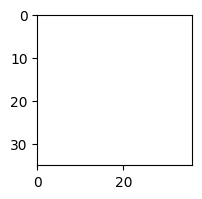

step 11, time taken so far: 0.078 s, complexity: 0


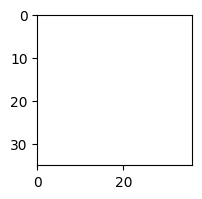

step 21, time taken so far: 0.153 s, complexity: 0


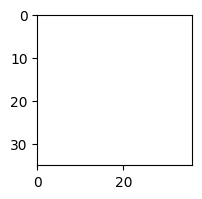

step 31, time taken so far: 0.226 s, complexity: 0


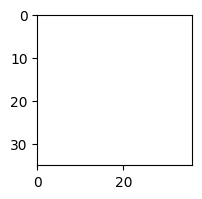

step 41, time taken so far: 0.299 s, complexity: 0


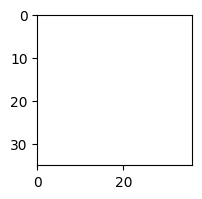

step 51, time taken so far: 0.370 s, complexity: 0


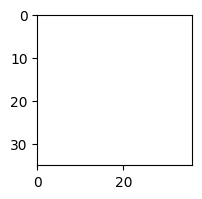

step 61, time taken so far: 0.441 s, complexity: 0


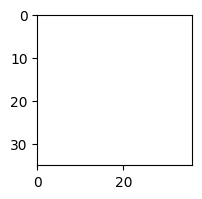

step 71, time taken so far: 0.516 s, complexity: 0


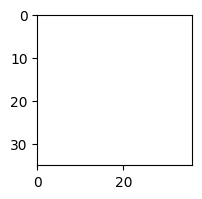

step 81, time taken so far: 0.858 s, complexity: 0


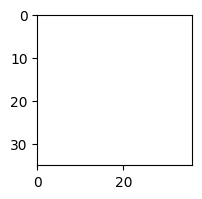

step 91, time taken so far: 0.928 s, complexity: 0


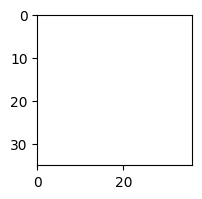

step 101, time taken so far: 1.001 s, complexity: 0


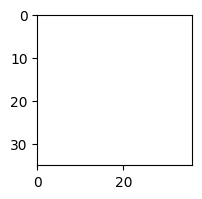

step 111, time taken so far: 1.072 s, complexity: 0


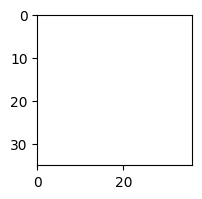

step 121, time taken so far: 1.142 s, complexity: 0


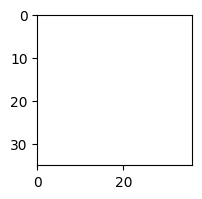

step 131, time taken so far: 1.214 s, complexity: 0


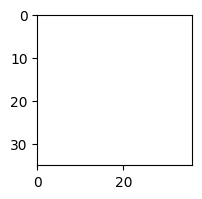

step 141, time taken so far: 1.285 s, complexity: 0


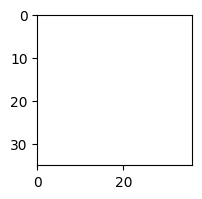

step 151, time taken so far: 1.364 s, complexity: 0


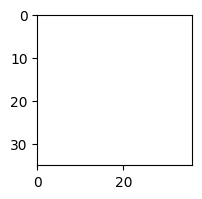

step 161, time taken so far: 1.439 s, complexity: 0


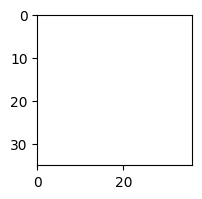

step 171, time taken so far: 1.513 s, complexity: 0


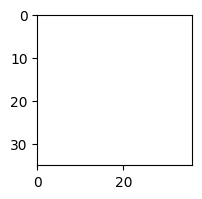

step 181, time taken so far: 1.589 s, complexity: 0


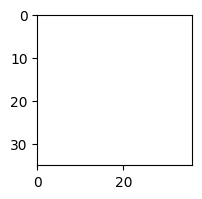

step 191, time taken so far: 1.663 s, complexity: 0


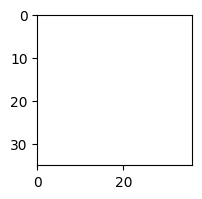

step 201, time taken so far: 1.735 s, complexity: 0


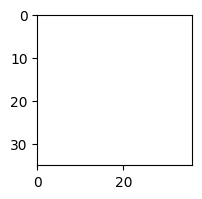

step 211, time taken so far: 1.810 s, complexity: 0


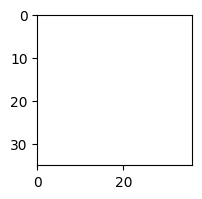

step 221, time taken so far: 1.883 s, complexity: 0


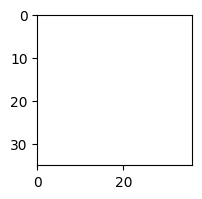

step 231, time taken so far: 1.954 s, complexity: 0


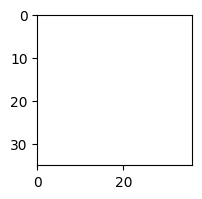

step 241, time taken so far: 2.030 s, complexity: 0


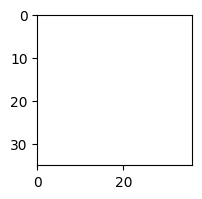

step 251, time taken so far: 2.104 s, complexity: 0


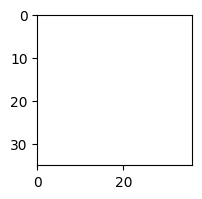

step 261, time taken so far: 2.176 s, complexity: 0


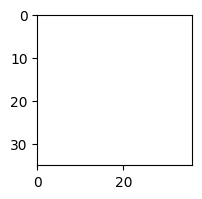

step 271, time taken so far: 2.250 s, complexity: 0


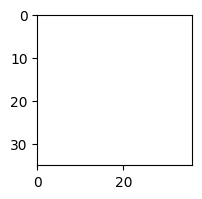

step 281, time taken so far: 2.323 s, complexity: 0


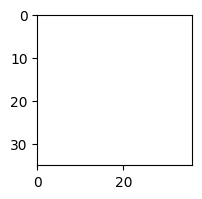

step 291, time taken so far: 2.397 s, complexity: 0


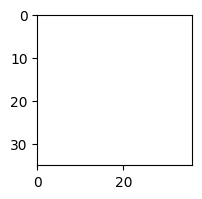

step 301, time taken so far: 2.472 s, complexity: 0


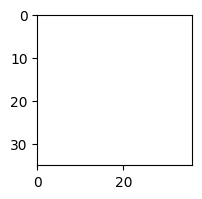

step 311, time taken so far: 2.544 s, complexity: 0


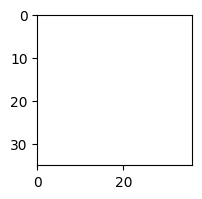

step 321, time taken so far: 2.617 s, complexity: 0


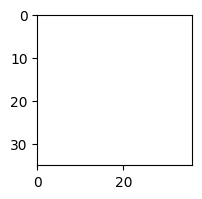

step 331, time taken so far: 2.695 s, complexity: 0


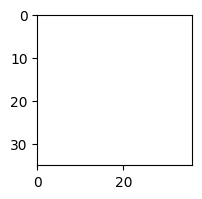

step 341, time taken so far: 2.771 s, complexity: 0


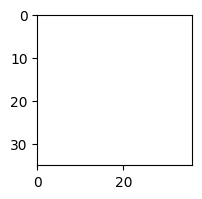

step 351, time taken so far: 2.846 s, complexity: 0


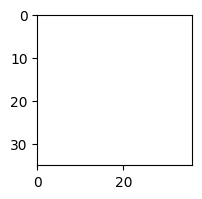

step 361, time taken so far: 2.918 s, complexity: 0


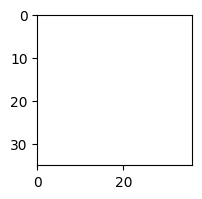

step 371, time taken so far: 2.988 s, complexity: 0


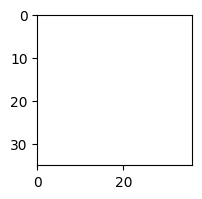

step 381, time taken so far: 3.064 s, complexity: 0


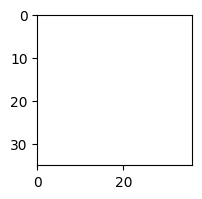

step 391, time taken so far: 3.137 s, complexity: 0


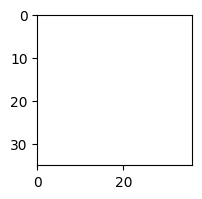

step 401, time taken so far: 3.209 s, complexity: 0


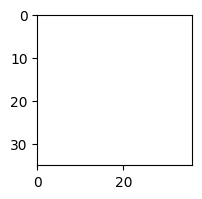

step 411, time taken so far: 3.283 s, complexity: 0


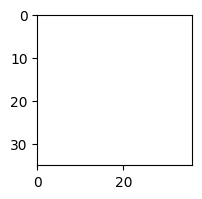

step 421, time taken so far: 3.356 s, complexity: 0


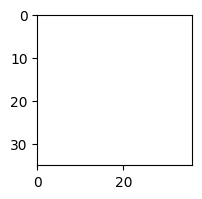

step 431, time taken so far: 3.431 s, complexity: 0


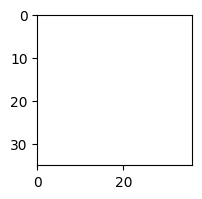

step 441, time taken so far: 3.506 s, complexity: 0


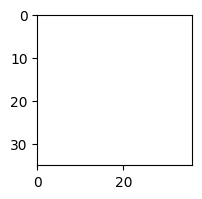

step 451, time taken so far: 3.579 s, complexity: 0


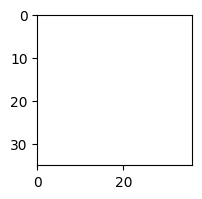

step 461, time taken so far: 3.649 s, complexity: 0


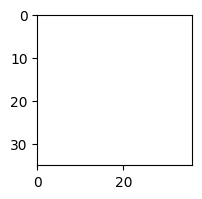

step 471, time taken so far: 3.723 s, complexity: 0


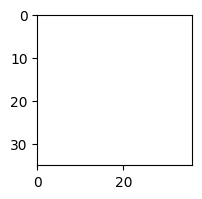

step 481, time taken so far: 3.821 s, complexity: 0


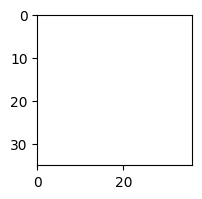

step 491, time taken so far: 3.896 s, complexity: 0


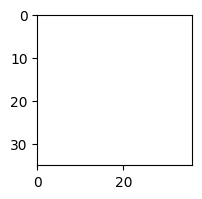

step 501, time taken so far: 3.970 s, complexity: 0


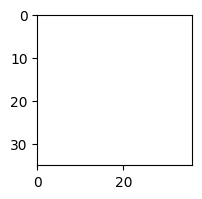

step 511, time taken so far: 4.043 s, complexity: 0


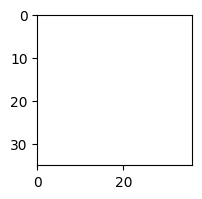

step 521, time taken so far: 4.114 s, complexity: 0


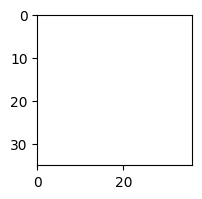

step 531, time taken so far: 4.190 s, complexity: 0


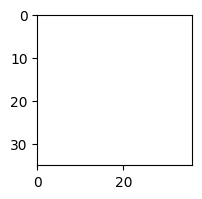

step 541, time taken so far: 4.263 s, complexity: 0


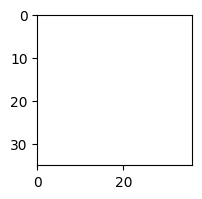

step 551, time taken so far: 4.338 s, complexity: 0


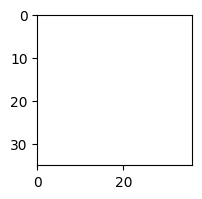

step 561, time taken so far: 4.412 s, complexity: 0


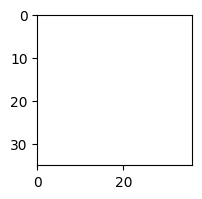

step 571, time taken so far: 4.485 s, complexity: 0


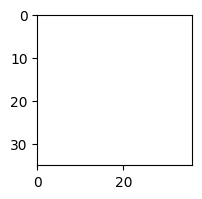

step 581, time taken so far: 4.558 s, complexity: 0


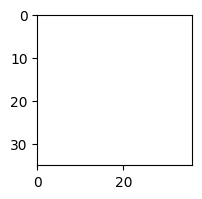

step 591, time taken so far: 4.631 s, complexity: 0


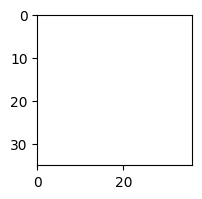

step 601, time taken so far: 4.704 s, complexity: 0


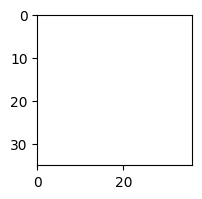

step 611, time taken so far: 4.777 s, complexity: 0


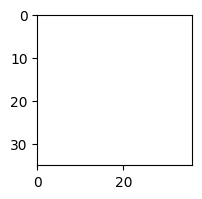

step 621, time taken so far: 4.855 s, complexity: 0


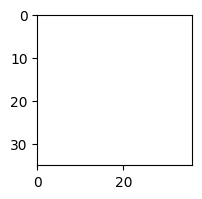

step 631, time taken so far: 4.927 s, complexity: 0


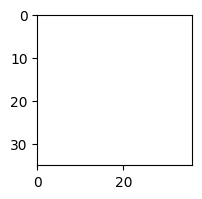

step 641, time taken so far: 5.000 s, complexity: 0


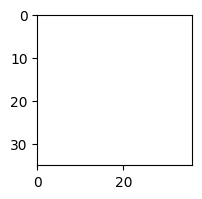

step 651, time taken so far: 5.072 s, complexity: 0


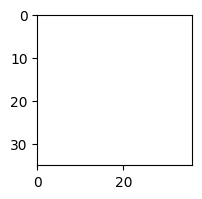

step 661, time taken so far: 5.143 s, complexity: 0


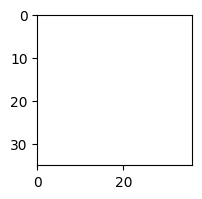

step 671, time taken so far: 5.218 s, complexity: 0


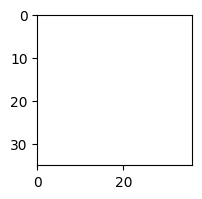

step 681, time taken so far: 5.288 s, complexity: 0


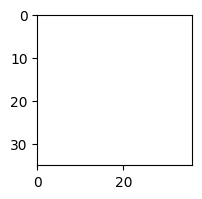

step 691, time taken so far: 5.361 s, complexity: 0


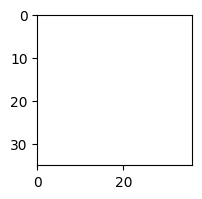

step 701, time taken so far: 5.436 s, complexity: 0


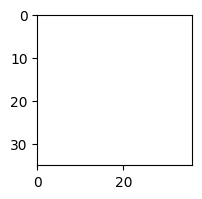

step 711, time taken so far: 5.507 s, complexity: 0


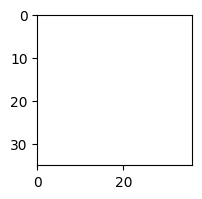

step 721, time taken so far: 5.577 s, complexity: 0


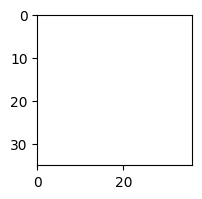

step 731, time taken so far: 5.649 s, complexity: 0


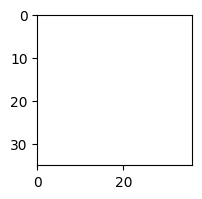

step 741, time taken so far: 5.722 s, complexity: 0


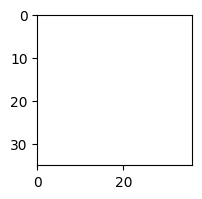

step 751, time taken so far: 5.794 s, complexity: 0


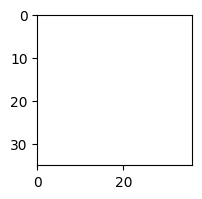

step 761, time taken so far: 5.870 s, complexity: 0


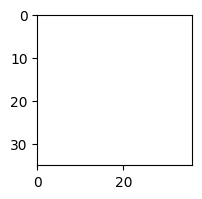

step 771, time taken so far: 5.942 s, complexity: 0


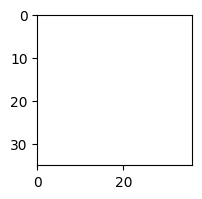

step 781, time taken so far: 6.012 s, complexity: 0


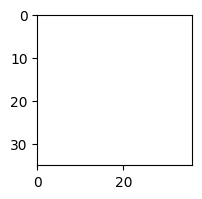

step 791, time taken so far: 6.084 s, complexity: 0


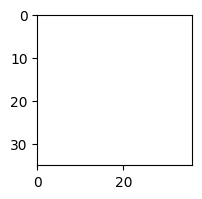

step 801, time taken so far: 6.154 s, complexity: 0


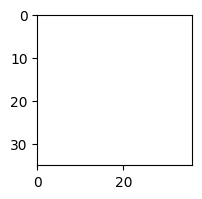

step 811, time taken so far: 6.227 s, complexity: 0


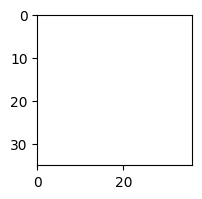

step 821, time taken so far: 6.302 s, complexity: 0


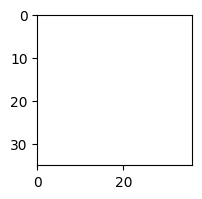

step 831, time taken so far: 6.377 s, complexity: 0


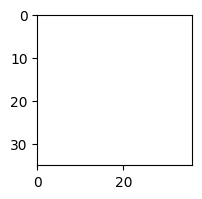

step 841, time taken so far: 6.450 s, complexity: 0


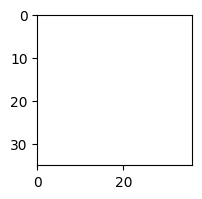

step 851, time taken so far: 6.521 s, complexity: 0


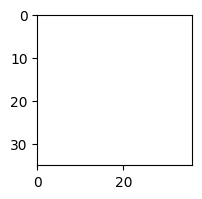

step 861, time taken so far: 6.600 s, complexity: 0


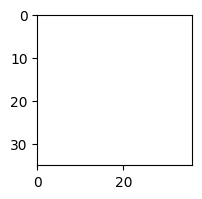

step 871, time taken so far: 6.676 s, complexity: 0


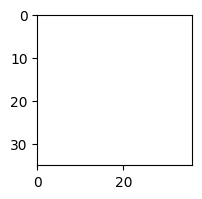

step 881, time taken so far: 6.746 s, complexity: 0


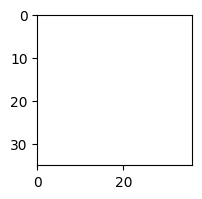

step 891, time taken so far: 6.816 s, complexity: 0


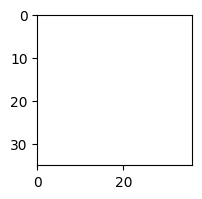

step 901, time taken so far: 6.889 s, complexity: 0


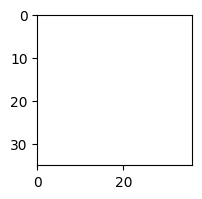

step 911, time taken so far: 6.959 s, complexity: 0


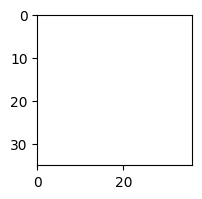

step 921, time taken so far: 7.031 s, complexity: 0


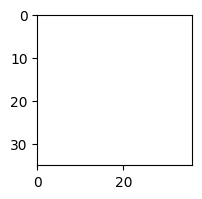

step 931, time taken so far: 7.102 s, complexity: 0


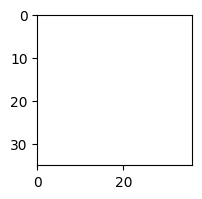

step 941, time taken so far: 7.173 s, complexity: 0


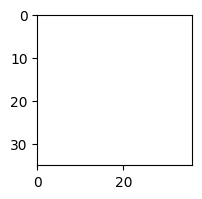

step 951, time taken so far: 7.244 s, complexity: 0


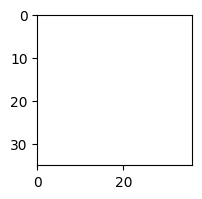

step 961, time taken so far: 7.317 s, complexity: 0


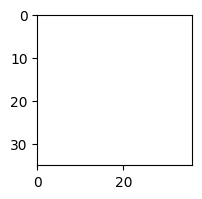

step 971, time taken so far: 7.388 s, complexity: 0


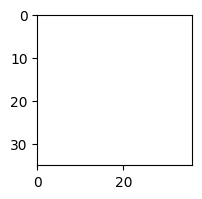

step 981, time taken so far: 7.466 s, complexity: 0


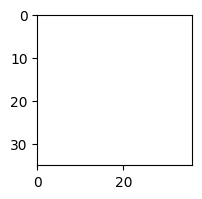

step 991, time taken so far: 7.538 s, complexity: 0


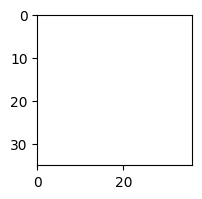

step 1001, time taken so far: 7.611 s, complexity: 0


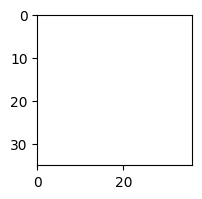

step 1011, time taken so far: 7.698 s, complexity: 0


KeyboardInterrupt: 

In [545]:
# Load our next puzzle
# rows, cols = get_test_puzzle('gridler.multisolve.json.txt')
rows, cols = get_actual_puzzle(268876)

srows = [Seq(row) for row in rows]
scols = [Seq(col) for col in cols]
field = Field(srows, scols)

prev = start
step = 0
debug_level = 0
Variant.unpacks_done = 0
start = time.perf_counter()

# Fire the solver
while field.solve_step():
    step += 1
    if step % 10 == 1:
        print(f'step {step}, time taken so far: {time.perf_counter() - start:.3f} s, complexity: {field.last_complexity()}')
        field.visualize()
    prev = time.perf_counter()

print(f"Solved in {step} steps :-)") if not 0 in field.mat else print("Unsolved :-(")
print(f" in {time.perf_counter() - start:.3f} s")
print(f"{Variant.unpacks_done=} (the expensive stuff)")
field.visualize()

# Current state:
#  Still No branching support 
